In [1]:
import pandas as pd
import herepy
from tqdm.notebook import tqdm
from collections import defaultdict
import re
import requests
import urllib
import xmltodict
import json
import numpy as np
#packages for R in python
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
#CPD
from pgmpy.models import BayesianModel
import pgmpy
# from pgmpy.estimators import ConstraintBasedEstimator
#bnlearn
import bnlearn
import torch
import pyro
import pyro.distributions as dist
from statistics import mean
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Image

%matplotlib inline

In [3]:
listings = pd.read_csv('data/listings.csv')
listings['is_location_exact'].unique()

array(['t', 'f'], dtype=object)

In [4]:
listings = listings[listings['is_location_exact'] == 't']

In [4]:
listings = listings[listings['property_type'].isin(['Apartment','Condominium'])]

In [5]:
listings = listings[listings['room_type']=='Entire home/apt']

In [6]:
listings = listings[listings['calendar_updated'].isin(['today','yesterday','2 days ago',
                                                       '3 days ago','4 days ago','5 days ago',
                                                       '6 days ago','a week ago','1 week ago',
                                                       '2 weeks ago','3 weeks ago','4 weeks ago',
                                                       '5 weeks ago','6 weeks ago','7 weeks ago',
                                                       '2 months ago','3 months ago','4 months ago',
                                                       '5 months ago','6 months ago','7 months ago',
                                                       '8 months ago','9 months ago','10 months ago',
                                                       '11 months ago','12 months ago'])]

In [7]:
listings = listings[listings['first_review'].notnull()]

In [11]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [39]:
def herePy(coordinate1,coordinate2):
    coordinates = coordinate1+','+coordinate2
    locator = Nominatim(user_agent="myGeocoder")
    address = locator.reverse(coordinates)
    address = address.raw
    return pd.Series([address.get('display_name',None),
                      address['address'].get('house_number',address['address'].get('building',None)),
                      address['address'].get('road',None),
                      address['address'].get('country',None),
                      address['address'].get('postcode',None)],
                     index=['Address','House','Street','Country',
                            'PostalCode'])

In [41]:
# locator = Nominatim(user_agent="myGeocoder")
# coordinates = '42.3547464,-71.0740765'
# location = locator.reverse(coordinates)
# location.raw
herePy('42.3547464','-71.0740765')

Address       135, Beacon Street, Beacon Hill, Boston, Suffo...
House                                                       135
Street                                            Beacon Street
Country                                United States of America
PostalCode                                                02116
dtype: object

In [42]:
listings[['Address','HouseNumber','Street','Country','PostalCode']] = listings.progress_apply(lambda row: herePy(str(row['latitude']), str(row['longitude'])) , axis=1)

In [43]:
lisiting_manual = pd.read_csv('data/listings_manual.csv')
listings_full   = lisiting_manual.merge(listings,on='id')

In [44]:
no_unique_columns = [x for y,x in enumerate(listings_full.columns) if len(set(list(listings_full[x])))==1]
listings_full = listings_full.drop(columns=no_unique_columns).reset_index(drop=True)

In [45]:
i = (0.04/12)   # Interest rate divided by 12
dr = 0.80       # Principal for mortgage
n  = 15*12      # 15 years mortgage
multiplier = (i*((1+i)**n))/(((1+i)**n)-1) # compound interest formula
listings_full['mortgage_p_month'] = (listings_full['Zestimate'].astype(float)*multiplier*dr).astype(int)

In [46]:
listings_full['annual_tax']  = (listings_full['Zestimate'].astype(float)*0.00804).astype(int)

In [47]:
listings_full['ins_p_month'] = (listings_full['Zestimate'].astype(float)*0.00035).astype(int)

In [48]:
listings_full['price'] = listings_full['price'].str.replace('$','')
listings_full['price'] = listings_full['price'].str.replace(',','').astype(float)

In [50]:
listings_full['roi'] = (listings_full['price']*340 - (
    (listings_full['mortgage_p_month']+ listings_full['ins_p_month'])*12 +
    listings_full['mortgage_p_month']))/(0.2*listings_full['Zestimate'].astype(float))*100

In [51]:
# Function to query `walkscore.com` to get the score for walking, transit and biking score
def walkScore(address,lat,lon,api,transit=1,bike=1):
    add  = re.sub('\s', '%', address)
    latitude = "&lat="+str(lat)
    longitude= "&lon="+str(lon)
    tran_code= "&transit="+str(transit)
    bike_code= "&bike="+str(bike)
    api_key  = "&wsapikey="+api
    api_url  = "http://api.walkscore.com/score?format=json&address="
    r = requests.get(api_url+add+latitude+longitude+tran_code+bike_code+api_key).json()
    walkScore = r['walkscore']
    bikeScore = r['bike']['score']
    trasitScore = r['transit']['score']
    return pd.Series([walkScore,bikeScore,trasitScore],index=['walkScore','bikeScore','transitScore'])

In [54]:
walkscoreAPI = 'b12d2c039749ebd2e8f67ffe0d9f2b83'
tqdm.pandas()
listings_full[['walkScore','bikeScore','transitScore']] = listings_full.progress_apply(
    lambda row:walkScore(row['Address'],row['latitude'], row['longitude'],api=walkscoreAPI), axis=1)

/Users/abdulrehman/opt/anaconda3/envs/Airbnb_Analysis/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [55]:
def schoolsNearMe(lat,lon,radius,greatSchoolsAPi):
    url_base  = "https://api.greatschools.org/schools/nearby?key="
    api       = greatSchoolsAPi+"&state=MA"
    lat_url   = "&lat="+str(lat)
    lon_url   = "&lon="+str(lon)
    radius_url= "&radius="+str(radius)

    url       =  url_base+api+lat_url+lon_url+radius_url

    contents = urllib.request.urlopen(url).read()
    my_dict=xmltodict.parse(contents)
    json_data=json.dumps(my_dict)
    json_data2 = json.loads(json_data)
    
    lister = [int(x['gsRating']) for x in json_data2['schools']['school'] if 'gsRating' in x.keys()]

    score = sum(lister)/len(lister)
    return pd.Series([score],index=['publicSchoolScores '])

In [ ]:
greatSchoolsAPi= #Enter API
listings_full[['publicSchoolScores']] = listings_full.progress_apply(lambda row: schoolsNearMe(row['latitude'], row['longitude'],radius=2,greatSchoolsAPi) , axis=1)

In [2]:
listings_full = pd.read_csv('data/listings_full.csv')

In [3]:
listings_subset = listings_full[['id','Zestimate','bedrooms','bathrooms','beds','accommodates','amenities_score',
               'bikeScore','walkScore','transitScore','neighbourhood_cleansed','property_type',
               'publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm','roi']]
pd.options.mode.chained_assignment = None 
listings_subset['property_type'] = listings_subset['property_type'].astype('category')
listings_subset['bathrooms'] = listings_subset['bathrooms'].astype('category')
listings_subset['neighbourhood'] = listings_subset['neighbourhood_cleansed'].astype('category')
del listings_subset['neighbourhood_cleansed']

listings_subset['roi'] = listings_subset['roi'].astype('float')
listings_subset['Zestimate'] = listings_subset['Zestimate'].astype('float')
listings_subset['bedrooms'] = listings_subset['bedrooms'].astype('float')
listings_subset['beds'] = listings_subset['beds'].astype('float')
listings_subset['accommodates'] = listings_subset['accommodates'].astype('float')
listings_subset['amenities_score'] = listings_subset['amenities_score'].astype('float')
listings_subset['publicSchoolScores'] = listings_subset['publicSchoolScores'].astype('float')
listings_subset['closenessToDowntown'] = listings_subset['closenessToDowntown'].astype('float')
listings_subset['price'] = listings_subset['price'].astype('float')
listings_subset['minimum_nights_avg_ntm'] = listings_subset['minimum_nights_avg_ntm'].astype('float')
pd.options.mode.chained_assignment = 'warn'

In [4]:
listing_cat = listings_subset[['bathrooms','bikeScore','walkScore','transitScore','property_type','neighbourhood']]
listings_n_cat = listings_subset[['roi','Zestimate','bedrooms','beds','accommodates','amenities_score','publicSchoolScores','closenessToDowntown','price','minimum_nights_avg_ntm']]

In [5]:
def rDiscretize(data):
    utils = importr('utils')
    utils.install_packages('bnlearn')
    # utils.install_packages('base')
    bnlearnR = importr('bnlearn')
    bnDiscretize = bnlearnR.discretize
    # Import Functions
    pandas2ri.activate()
    r_dt = ro.conversion.py2rpy(data) #convert pandas to RDataframe
    r_dt2 = bnDiscretize(r_dt,method= "hartemink", breaks = 3, ibreaks=3)
    pd_dt = ro.conversion.rpy2py(r_dt2)
    pd_dt.reset_index(drop=True)
    return pd_dt

In [6]:
listings_fac = rDiscretize(listings_n_cat)

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Australia (Perth) [https]
 6: Austria [https]
 7: Belgium (Ghent) [https]
 8: Brazil (BA) [https]
 9: Brazil (PR) [https]
10: Brazil (RJ) [https]
11: Brazil (SP 1) [https]
12: Brazil (SP 2) [https]
13: Bulgaria [https]
14: Canada (MB) [https]
15: Chile (Santiago) [https]
16: China (Beijing 2) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Guangzhou) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 1) [https]
23: China (Shanghai 2) [https]
24: Costa Rica [https]
25: Denmark [https]
26: East Asia [https]
27: Ecuador (Cuenca) [https]
28: Ecuador (Quito) [https]
29: Estonia [https]
30: France (Lyon 1) [https]
31: France (Lyon 2) [https]
32: France (Marseille) [https]
33: France (Montpellier) [https]
34: Germany (Erlangen

R[write to console]: trying URL 'https://cran.case.edu/bin/macosx/el-capitan/contrib/3.6/bnlearn_4.6.1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2653896 bytes (2.5 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R


The downloaded binary packages are in
	/var/folders/40/1cmwtr_5693092wp0mnttzgh0000gn/T//Rtmp7KW9Nh/downloaded_packages


In [7]:
data_discrete = listings_fac.reset_index(drop=True).join(listing_cat)

In [8]:
nodes = ['amenities_score','bathrooms','bedrooms','transitScore','Zestimate','neighbourhood',
         'roi','price','minimum_nights_avg_ntm','bikeScore','walkScore','publicSchoolScores',
         'property_type','closenessToDowntown','accommodates','beds']

In [9]:
edges = [('amenities_score','price'),
         ('bathrooms','price'),
         ('bathrooms','Zestimate'),
         ('bedrooms','price'),
         ('bedrooms','beds'),
         ('bedrooms','accommodates'),
         ('bedrooms','Zestimate'),
         ('property_type','price'),
         ('property_type','Zestimate'),
         ('price','roi'),
         ('transitScore','Zestimate'),
         ('transitScore','price'),
         ('Zestimate', 'price'),
         ('Zestimate','roi'),
         ('bikeScore','price'),
         ('walkScore','price'),
         ('beds','price'),
         ('accommodates','price'),
         ('neighbourhood','price'),
         ('neighbourhood','transitScore'),
         ('neighbourhood','publicSchoolScores'),
         ('neighbourhood','bikeScore'),
         ('publicSchoolScores','Zestimate'),
         ('neighbourhood','Zestimate'),
         ('neighbourhood','closenessToDowntown'),
         ('closenessToDowntown','price'),                    
         ('minimum_nights_avg_ntm','price')]

In [10]:
from pgmpy.models import BayesianModel
graph = BayesianModel()

graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

In [11]:
def adjacencyMatrix(edges):
    df = pd.DataFrame(edges, columns =['source','target'], dtype = float) 
    df = pd.crosstab(df.source, df.target)
    idx = df.columns.union(df.index)
    df2 = df.reindex(index = idx, columns=idx, fill_value=0)
    df2.index.name = "source"
    df2 = df2.rename_axis('target')
    return df2

In [12]:
adjMat = adjacencyMatrix(edges)

In [13]:
# adjMat

In [14]:
data_discrete = data_discrete.astype(object)

In [15]:
model ={'adjmat':adjMat, 'model':graph}

model_update = bnlearn.parameter_learning.fit(model, data_discrete, verbose=1)

In [16]:
labels ={}
for i in list(model_update['model'].nodes):
    labels[i] = model_update['model'].get_cpds(i).state_names[i]

In [17]:
params_amenities_score          = torch.tensor(model_update['model'].get_cpds('amenities_score').values.T)
params_bathrooms                = torch.tensor(model_update['model'].get_cpds('bathrooms').values.T)
params_bedrooms                 = torch.tensor(model_update['model'].get_cpds('bedrooms').values.T)
params_minimum_nights_avg_ntm   = torch.tensor(model_update['model'].get_cpds('minimum_nights_avg_ntm').values.T)
params_bikeScore                = torch.tensor(model_update['model'].get_cpds('bikeScore').values.T)
params_walkScore                = torch.tensor(model_update['model'].get_cpds('walkScore').values.T)
params_property_type            = torch.tensor(model_update['model'].get_cpds('property_type').values.T)
params_neighbourhood            = torch.tensor(model_update['model'].get_cpds('neighbourhood').values.T)
params_accommodates             = torch.tensor(model_update['model'].get_cpds('accommodates').values.T)
params_beds                     = torch.tensor(model_update['model'].get_cpds('beds').values.T)
params_closenessToDowntown      = torch.tensor(model_update['model'].get_cpds('closenessToDowntown').values.T)
params_transitScore             = torch.tensor(model_update['model'].get_cpds('transitScore').values.T)
params_publicSchoolScores       = torch.tensor(model_update['model'].get_cpds('publicSchoolScores').values.T)
params_Zestimate                = torch.tensor(model_update['model'].get_cpds('Zestimate').values.T)
params_price                    = torch.tensor(model_update['model'].get_cpds('price').values.T)
params_roi                      = torch.tensor(model_update['model'].get_cpds('roi').values.T)

In [18]:
def pyroModel():
    amenities_score         = pyro.sample('amenities_score',        dist.Categorical(params_amenities_score))
    bathrooms               = pyro.sample('bathrooms',dist.Categorical(params_bathrooms))
    bedrooms                = pyro.sample('bedrooms', dist.Categorical(params_bedrooms))
    minimum_nights_avg_ntm  = pyro.sample('minimum_nights_avg_ntm', dist.Categorical(params_minimum_nights_avg_ntm))
    bikeScore               = pyro.sample('bikeScore',dist.Categorical(params_bikeScore))
    walkScore               = pyro.sample('walkScore',              dist.Categorical(params_walkScore))
    property_type           = pyro.sample('property_type',          dist.Categorical(params_property_type))
    neighbourhood           = pyro.sample('neighbourhood',          dist.Categorical(params_neighbourhood))
    accommodates            = pyro.sample('accommodates',           dist.Categorical(params_accommodates[bedrooms]))
    beds                    = pyro.sample('beds',dist.Categorical(params_beds[bedrooms]))
    closenessToDowntown     = pyro.sample('closenessToDowntown',   dist.Categorical(params_closenessToDowntown[neighbourhood]))
    transitScore            = pyro.sample('transitScore',           dist.Categorical(params_transitScore[neighbourhood]))
    publicSchoolScores      = pyro.sample('publicSchoolScores',     dist.Categorical(params_publicSchoolScores[neighbourhood]))
    Zestimate               = pyro.sample('Zestimate',dist.Categorical(params_Zestimate[transitScore][publicSchoolScores][property_type][neighbourhood][bedrooms][bathrooms]))
    price                   = pyro.sample('price',dist.Categorical(params_price[walkScore][transitScore][property_type][neighbourhood][minimum_nights_avg_ntm][closenessToDowntown][bikeScore][beds][bedrooms][bathrooms][amenities_score][accommodates][Zestimate]))
    roi                     = pyro.sample('roi',dist.Categorical(params_roi[price][Zestimate]))
    return amenities_score,bathrooms,bedrooms,minimum_nights_avg_ntm,bikeScore,walkScore,property_type,neighbourhood,accommodates,beds,closenessToDowntown,transitScore,publicSchoolScores,Zestimate,price,roi

In [19]:
#intervention on single node
def UsingDo(data,value):
    intervention_model = pyro.do(pyroModel, data={data: torch.tensor(value)})
    posterior = pyro.infer.Importance(intervention_model, num_samples=5000).run()
    marginal = EmpiricalMarginal(posterior,"roi")
    samples = [marginal().item() for _ in range(1000)]
    
    unique, counts = np.unique(samples, return_counts=True)
    prob = counts[1]/sum(counts)
    
    return(prob)

In [24]:
def UsingConditional(data,value):
    conditioned_model = pyro.condition(pyroModel, data={data: torch.tensor(value)})
    posterior = pyro.infer.Importance(conditioned_model, num_samples=5000).run()
    marginal = EmpiricalMarginal(posterior,"roi")
    samples = [marginal().item() for _ in range(1000)]
    
    unique, counts = np.unique(samples, return_counts=True)
    prob = counts[1]/sum(counts)
  
    return(prob)

In [21]:
pyro.set_rng_seed(10)
#Probability of ROI fixing the bedrooms using do operator
for i in range(len(labels['bedrooms'])):
    val = UsingDo('bedrooms', i)
    print(labels['bedrooms'][i],':',val)

(1,2] : 0.356
(2,6] : 0.349
[0,1] : 0.341


In [23]:
pyro.set_rng_seed(10)
for i in range(len(labels['bedrooms'])):
    val = UsingConditional('bedrooms', i)
    print(labels['bedrooms'][i],':',val)

(1,2] : 0.324
(2,6] : 0.327
[0,1] : 0.329


In [25]:
pyro.set_rng_seed(10)
for i in range(len(labels['bathrooms'])):
    val = UsingDo('bathrooms', i)
    print(labels['bathrooms'][i],':',val)

1.0 : 0.354
1.5 : 0.348
2.0 : 0.342
2.5 : 0.311
3.0 : 0.309


In [26]:
pyro.set_rng_seed(10)
for i in range(len(labels['bathrooms'])):
    val = UsingConditional('bathrooms', i)
    print(labels['bathrooms'][i],':',val)

1.0 : 0.323
1.5 : 0.327
2.0 : 0.327
2.5 : 0.325
3.0 : 0.341


In [28]:
#Probability of ROI fixing the amenities_score using do
pyro.set_rng_seed(10)
for i in range(len(params_amenities_score)):
    val = UsingDo('amenities_score', i)
    print(labels['amenities_score'][i],':',val)

(30,33] : 0.357
(33,52] : 0.35
[12,30] : 0.342


In [30]:
pyro.set_rng_seed(10)
for i in range(len(params_amenities_score)):
    val = UsingConditional('amenities_score', i)
    print(labels['amenities_score'][i],':',val)

(30,33] : 0.323
(33,52] : 0.33
[12,30] : 0.327


In [31]:
pyro.set_rng_seed(10)
for i in range(len(params_walkScore)):
    val = UsingDo('walkScore', i)
    print(labels['walkScore'][i],':',val)

3 : 0.357
4 : 0.35
5 : 0.342


In [32]:
pyro.set_rng_seed(10)
for i in range(len(params_walkScore)):
    val = UsingConditional('walkScore', i)
    print(labels['walkScore'][i],':',val)

3 : 0.324
4 : 0.326
5 : 0.329


In [33]:
pyro.set_rng_seed(10)
for i in range(len(params_bikeScore)):
    val = UsingDo('bikeScore', i)
    print(labels['bikeScore'][i],':',val)

1 : 0.357
2 : 0.35
3 : 0.342
4 : 0.312


In [34]:
pyro.set_rng_seed(10)
for i in range(len(params_bikeScore)):
    val = UsingConditional('bikeScore', i)
    print(labels['bikeScore'][i],':',val)

1 : 0.324
2 : 0.326
3 : 0.329
4 : 0.328


In [35]:
pyro.set_rng_seed(10)
for i in range(len(labels['closenessToDowntown'])):
    val = UsingDo('closenessToDowntown', i)
    print(labels['closenessToDowntown'][i],':',val)

(2400.33,4704.33] : 0.357
(4704.33,19715] : 0.35
[898,2400.33] : 0.342


In [36]:
pyro.set_rng_seed(10)
for i in range(len(labels['closenessToDowntown'])):
    val = UsingConditional('closenessToDowntown', i)
    print(labels['closenessToDowntown'][i],':',val)

(2400.33,4704.33] : 0.324
(4704.33,19715] : 0.327
[898,2400.33] : 0.347


In [37]:
pyro.set_rng_seed(10)
for i in range(len(labels['transitScore'])):
    val = UsingDo('transitScore', i)
    print(labels['transitScore'][i],':',val)

2 : 0.355
3 : 0.348
4 : 0.341
5 : 0.314


In [38]:
for i in range(len(labels['transitScore'])):
    val = UsingConditional('transitScore', i)
    print(labels['transitScore'][i],':',val)

2 : 0.353
3 : 0.317
4 : 0.35
5 : 0.326


In [39]:
pyro.set_rng_seed(10)
for i in range(len(labels['publicSchoolScores'])):
    val = UsingDo('publicSchoolScores', i)
    print(labels['publicSchoolScores'][i],':',val)

(3.47373,3.70142] : 0.354
(3.70142,5.27273] : 0.353
[2.75,3.47373] : 0.34


In [40]:
pyro.set_rng_seed(10)
for i in range(len(labels['publicSchoolScores'])):
    val = UsingConditional('publicSchoolScores', i)
    print(labels['publicSchoolScores'][i],':',val)

(3.47373,3.70142] : 0.368
(3.70142,5.27273] : 0.341
[2.75,3.47373] : 0.354


In [41]:
pyro.set_rng_seed(10)
new_df = pd.DataFrame(columns=['neighbourhood', 'simple_ROI','complex_ROI','Causal Effect'])
for i in range(len(params_neighbourhood)):
    intervention_model_simple = pyro.do(pyroModel, data={'neighbourhood': torch.tensor(i)})
    posterior_simple = pyro.infer.Importance(intervention_model_simple, num_samples=5000).run()
    marginal_simple = EmpiricalMarginal(posterior_simple,"roi")
    samples_simple = [marginal_simple().item() for _ in range(1000)]
    unique, counts = np.unique(samples_simple, return_counts=True)
    roi_neigh1 = counts[1]/sum(counts)


    intervention_model_complex = pyro.do(pyroModel, data={'neighbourhood': torch.tensor(i),'amenities_score':torch.tensor(0),\
                                                        'bikeScore':torch.tensor(1) ,'walkScore':torch.tensor(0) , \
                                                        'publicSchoolScores':torch.tensor(0), 'transitScore': torch.tensor(0),\
                                                        'closenessToDowntown': torch.tensor(0), 'bedrooms': torch.tensor(0),\
                                                        'bathrooms': torch.tensor(0)} )
    posterior_complex = pyro.infer.Importance(intervention_model_complex, num_samples=5000).run()
    marginal_complex = EmpiricalMarginal(posterior_complex,"roi")
    samples_complex = [marginal_complex().item() for _ in range(1000)]
    unique, counts = np.unique(samples_complex, return_counts=True)
    roi_neigh2 = counts[1]/sum(counts)

    new_df.loc[i] = [labels['neighbourhood'][i] , roi_neigh1, roi_neigh2, roi_neigh2-roi_neigh1]


new_df

,neighbourhood,simple_ROI,complex_ROI,Causal Effect
0,Allston,0.355,0.349,-0.006
1,Back Bay,0.340,0.311,-0.029
2,Bay Village,0.308,0.339,0.031
3,Beacon Hill,0.333,0.364,0.031
4,Brighton,0.341,0.327,-0.014
5,Charlestown,0.308,0.325,0.017
6,Chinatown,0.326,0.308,-0.018
7,Dorchester,0.361,0.331,-0.030
8,Downtown,0.336,0.348,0.012
9,East Boston,0.335,0.338,0.003


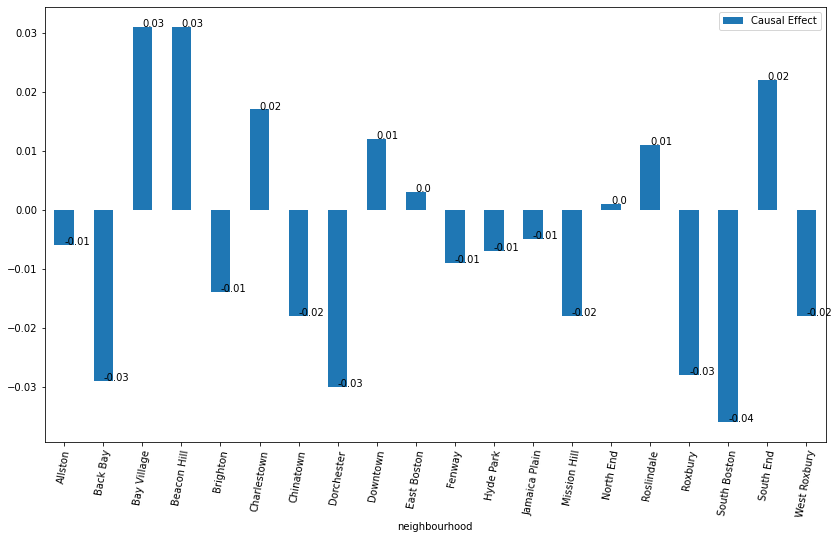

In [42]:
pyro.set_rng_seed(10)
fig, ax = plt.subplots(figsize=(14,8))
new_df.plot.bar(x = 'neighbourhood', y = ['Causal Effect'], rot = 80, ax = ax)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()))

In [43]:
pyro.set_rng_seed(10)
bedbathmodel = pyro.condition(pyroModel, data = {"bedrooms": torch.tensor(0),"bathrooms":torch.tensor(0)})
beds_low = pyro.do(bedbathmodel, data={'beds': torch.tensor(0)})
roi_posterior = pyro.infer.Importance(beds_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
low_beds = roi_counts[1]/sum(roi_counts)

beds_high = pyro.do(bedbathmodel, data={'beds': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(beds_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
high_beds = roi_counts[1]/sum(roi_counts)

low_beds - high_beds

0.00379999999999997

In [44]:
price_downtown = pyro.condition(pyroModel, data = {"price": torch.tensor(0),"closenessToDowntown":torch.tensor(1)})

In [45]:
pyro.set_rng_seed(10)
minnights_low = pyro.do(price_downtown, data={'minimum_nights_avg_ntm': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(minnights_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
minnights_low_val = roi_counts[1]/sum(roi_counts)

minnights_high = pyro.do(price_downtown, data={'minimum_nights_avg_ntm': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(minnights_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
minnights_high_val = roi_counts[1]/sum(roi_counts)

minnights_high_val - minnights_low_val

0.019000000000000017

In [46]:
med_price = pyro.condition(pyroModel, data = {"price": torch.tensor(0)})

In [47]:
pyro.set_rng_seed(10)
accommodates_low = pyro.do(med_price, data={'accommodates': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(accommodates_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
roi_accommodates_low = roi_counts[1]/sum(roi_counts)

accommodates_high = pyro.do(med_price, data={'accommodates': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(accommodates_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
roi_accommodates_high = roi_counts[1]/sum(roi_counts)

roi_accommodates_high - roi_accommodates_low

0.012199999999999989

In [48]:
bedrooms_med = pyro.condition(pyroModel, data = {"bedrooms": torch.tensor(0)})

In [49]:
pyro.set_rng_seed(10)
accommodates_low = pyro.do(bedrooms_med, data={'accommodates': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(accommodates_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
bedrooms_accommodates_low = roi_counts[1]/sum(roi_counts)

accommodates_high = pyro.do(bedrooms_med, data={'accommodates': torch.tensor(0)})
roi_posterior = pyro.infer.Importance(accommodates_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
bedrooms_accommodates_high = roi_counts[1]/sum(roi_counts)

bedrooms_accommodates_high - bedrooms_accommodates_low

-0.0005999999999999894

In [50]:
neigh_downtown = pyro.condition(pyroModel, data = {"neighbourhood": torch.tensor(5)})

In [51]:
pyro.set_rng_seed(10)
pss_low = pyro.do(neigh_downtown, data={'publicSchoolScores': torch.tensor(2)})
roi_posterior = pyro.infer.Importance(pss_low, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
downtown_pss_low = roi_counts[1]/sum(roi_counts)

pss_high = pyro.do(neigh_downtown, data={'publicSchoolScores': torch.tensor(1)})
roi_posterior = pyro.infer.Importance(pss_high, num_samples=5000).run()
roi_marginal = EmpiricalMarginal(roi_posterior,"roi")
roi_samples = [roi_marginal().item() for _ in range(5000)]
roi_unique, roi_counts = np.unique(roi_samples, return_counts=True)
downtown_pss_high = roi_counts[1]/sum(roi_counts)

downtown_pss_low - downtown_pss_high

0.0020000000000000018

In [54]:
mobility = "/Users/abdulrehman/Downloads/Region_Mobility_Report_CSVs/2020_US_Region_Mobility_Report.csv"
mobility = pd.read_csv(mobility)

In [64]:
mobility= mobility['sub_region_2'=='Massachusetts']

KeyError: False